# Deep Learning &mdash; Assignment 5

Fifth assignment for the 2022 Deep Learning course (NWI-IMC070) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_October 2022_

-----

**Names:** Hauque, Federico - Soler Sanz, Guillem

**Group:** 5

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Construct a PyTorch `DataSet`
1. Train and modify a transformer network
1. Experiment with a translation dataset

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` for PyTorch,
* `d2l`, the library that comes with the [Dive into deep learning](https://d2l.ai) book.  
  Note: if you get errors, make sure the right version of the d2l library is installed:
  `pip install d2l==1.0.0a1.post0`

All libraries can be installed with `pip install`.

In [ ]:
!pip install torch
!pip install d2l==1.0.0a1.post0
%matplotlib inline
from d2l import torch as d2l
import math
from random import Random
from typing import List
import numpy as np
import torch
from torch import nn
from torch.utils.data import (IterableDataset, DataLoader)
import matplotlib.pyplot as plt

device = d2l.try_gpu()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## 5.1 Learning to calculate (5 points)

In this assignment we are going to train a neural network to do mathematics.
When communicating between humans, mathematics is expressed with words and formulas.
The simplest of these are formulas with a numeric answer. For example, we might ask what is `100+50`, to which the answer is `150`.

To teach a computer how to do this task, we are going to need a dataset.

Below is a function that generates a random formula. Study it, and see if you understand its parameters.

In [ ]:
def random_integer(length: int, signed: bool = True, rng: Random = Random()):
    max = math.pow(10, length)
    min = -max if signed else 0
    return rng.randint(min, max)

def random_formula(complexity: int, signed: bool = True, rng: Random = Random()):
    """
    Generate a random formula of the form "a+b" or "a-b".
    complexity is the maximum number of digits in the numbers.
    """
    a = random_integer(complexity, signed, rng)
    b = random_integer(complexity, False, rng)
    is_addition = not signed or rng.choice([False, True])
    if is_addition:
        return (f"{a}+{b}", str(a + b))
    else:
        return (f"{a}-{b}", str(a - b))

In [ ]:
seed = None
random_formula(3, rng=Random(seed))

('838-984', '-146')

Note that the `rng` argument allows us to reproduce the same random numbers, which you can verify by running the code below multiple times. But if you change the seed to `None` then the random generator is initialized differently each time.

In [ ]:
def random_formulas(complexity, signed, count, seed):
    """
    Iterator that yields the given count of random formulas
    """
    rng = Random(seed)
    for i in range(count):
        yield random_formula(complexity, signed, rng=rng)

for q, a in random_formulas(3, True, 5, seed):
    print(f'{q} = {a}')

896-302 = 594
-713-540 = -1253
198-160 = 38
-51+12 = -39
343-782 = -439


We are going to treat these expressions as sequences of tokens, where each character is a token. In addition we will need tokens to denote begin-of-sequence and end-of-sequence, as well as padding, for which we will use `'<bos>'`, `'<eos>'`, and `'<pad>'` respectively, as is done in the book.

[d2l chapter 9.2](https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html) includes an example of tokenizing a string, and it also defines a `Vocab` class that handles converting the tokens to numbers.

For this dataset we know beforehand what the vocabulary will be.

### Creating a vocabulary

**(a) What are the tokens in this dataset? Complete the code below.<span style="float:right"> (1 point)</span>**

In [ ]:
vocab = d2l.Vocab(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '*', '/'], reserved_tokens=['<bos>', '<eos>', '<pad>'])

We can print the vocabulary to double check that it makes sense:

In [ ]:
print('Vocabulary size:', len(vocab))
print('Vocabulary:', vocab.idx_to_token)

Vocabulary size: 18
Vocabulary: ['*', '+', '-', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<bos>', '<eos>', '<pad>', '<unk>']


Note that the d2l Vocab class includes a `'<unk>'` token, for handling unknown tokens in the input.

We are now ready to tokenize and encode formula.

**(b) Complete the code below.<span style="float:right"> (1 point)</span>**

In [ ]:
def tokenize_and_encode(string: str, vocab=vocab) -> List[int]:
  tokens = list(string)
  tokens.append('<eos>')
  return vocab[tokens[:]]

Let's test it on a random formula:

In [ ]:
q, a = random_formula(3, rng=Random(seed))
print('The question', q, 'and answer', a)
print('are encoded as', tokenize_and_encode(q), 'and', tokenize_and_encode(a))
assert ''.join(vocab.to_tokens(tokenize_and_encode(q))) == q + '<eos>'

The question 943+641 and answer 1584
are encoded as [13, 8, 7, 1, 10, 8, 5, 15] and [5, 9, 12, 8, 15]


### Padding and trimming

Next, to be able to work with a whole dataset of these encoded sequences, they all need to be the same length.

**(c) Implement the function below that pads or trims the encoded token sequence as needed.<span style="float:right"> (1 point)</span>**

Hint: see [d2l section 10.5.3](http://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html#loading-sequences-of-fixed-length) for a very similar function.

In [ ]:
def pad_or_trim(tokens: List[int], target_length: int, vocab=vocab):
    if(len(tokens) < target_length):
      for _ in range(len(tokens), target_length):
        tokens.append(vocab['<pad>'])
    elif(len(tokens) > target_length):
      tokens = tokens[0:target_length]
    return tokens

In [ ]:
# pad or trim q to get a sequence of 10 tokens
pad_or_trim(tokenize_and_encode(q), 10)

[13, 8, 7, 1, 10, 8, 5, 15, 16, 16]

### Translating tokens

We can use `vocab.to_tokens` to convert the encoded token sequence back to something more readable:

In [ ]:
vocab.to_tokens(pad_or_trim(tokenize_and_encode(q), 10))

['9', '4', '3', '+', '6', '4', '1', '<eos>', '<pad>', '<pad>']

For convenience, we define the `decode_tokens` function to convert entire lists or tensors:

In [ ]:
def decode_tokens(t):
    # convert a list, tensor, or array of encoded tokens
    if isinstance(t, torch.Tensor):
        t = t.detach().cpu().numpy()
    t = np.asarray(t)
    return np.asarray(vocab.to_tokens(list(t.flatten()))).reshape(*t.shape)

# convert all tokens at once
print(decode_tokens([pad_or_trim(tokenize_and_encode('513+1323'), 10),
                     pad_or_trim(tokenize_and_encode('412+42'), 10)]))

[['5' '1' '3' '+' '1' '3' '2' '3' '<eos>' '<pad>']
 ['4' '1' '2' '+' '4' '2' '<eos>' '<pad>' '<pad>' '<pad>']]


### Creating a dataset

The most convenient way to use a data generating function for training a neural network is to wrap it in a PyTorch `Dataset`. In this case, we will use an [IterableDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset), which can be used as an iterator to walk over the samples in the dataset.

**(d) Complete the code below.<span style="float:right"> (1 point)</span>**

In [ ]:
class FormulaDataset(IterableDataset):
    def __init__(self, complexity, signed, count, seed=None, vocab=vocab):
        self.seed = seed
        self.complexity = complexity
        self.signed = signed
        self.count = count
        self.vocab = vocab
        self.max_question_length = 2 * complexity + 3
        self.max_answer_length = complexity + 2

    def __iter__(self):
      for q, a in random_formulas(self.complexity, self.signed, self.count, self.seed):
        tokens_q = tokenize_and_encode(q, self.vocab)
        tokens_a = tokenize_and_encode(a, self.vocab)
        padded_q = pad_or_trim(tokens_q, self.max_question_length, self.vocab)
        padded_a = pad_or_trim(tokens_a, self.max_answer_length, self.vocab)
        yield torch.tensor(padded_q), torch.tensor(padded_a)

**(e) Define a training set with 10000 formulas and a validation set with 5000 formulas, both with complexity 3.<span style="float:right"> (1 point)</span>**

---



Note: make sure that the training and validation set are different.

In [ ]:
complexity = 3
signed = True
train_data = FormulaDataset(complexity, signed, 10000, 797989)
val_data   = FormulaDataset(complexity, signed, 5000, 232653)

As usual, we wrap each dataset in a `DataLoader` to create minibatches.

In [ ]:
# Define data loaders
batch_size = 125
data_loaders = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=batch_size),
    'val':   torch.utils.data.DataLoader(val_data, batch_size=batch_size),
}

# Verify that train and validation are different but deterministic
train_loader = data_loaders['train']
val_loader = data_loaders['val']
assert torch.equal(next(iter(train_loader))[0], next(iter(train_loader))[0])
assert torch.equal(next(iter(val_loader))[0], next(iter(val_loader))[0])
assert not torch.equal(next(iter(train_loader))[0], next(iter(val_loader))[0])

## 5.2 Transformer inputs (10 points)

There is a detailed description of the transformer model in [chapter 11 of the d2l book](http://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html). We will not use most the code from the book, and instead use [PyTorch's built-in Transformer layers](https://pytorch.org/docs/stable/nn.html#transformer-layers).

However, some details we still need to implement ourselves.

### Masks

Training a transformer uses masked self-attention, so we need some masks. Here are two functions that make these masks.

In [ ]:
def generate_square_subsequent_mask(size, device=device):
    """
    Mask that indicates that tokens at a position are not allowed to attend to
    tokens in subsequent positions.
    """
    mask = (torch.tril(torch.ones((size, size), device=device))) == 0
    return mask

def generate_padding_mask(tokens, padding_token):
    """
    Mask that indicates which tokens should be ignored because they are padding.
    """
    return tokens == torch.tensor(padding_token)

**(a) Generate a padding mask for a random encoded token string.<span style="float:right"> (1 point)</span>**

Hint: make sure that `tokens` is a torch.tensor.

In [ ]:
q, a = random_formula(3, rng=Random(seed))
tokens = torch.tensor(pad_or_trim(tokenize_and_encode(q, vocab), 9))
padding_mask = generate_padding_mask(tokens, vocab['<pad>'])
print(tokens)
print(decode_tokens(tokens))
print(padding_mask)

tensor([11,  5,  2,  8, 12, 10, 15, 16, 16])
['7' '1' '-' '4' '8' '6' '<eos>' '<pad>' '<pad>']
tensor([False, False, False, False, False, False, False,  True,  True])


**(b) How will this mask be used by a transformer?<span style="float:right"> (1 point)</span>**

It will be useful to tell easily which tokens have actual acontent and which are just padding.

The code below takes the first batch of data from the training set, and it generates a shifted version of the target values.

In [ ]:
x, y = next(iter(train_loader))
bos = torch.tensor(vocab['<bos>']).expand(y.shape[0], 1)
y_prev = torch.cat((bos, y[:,:-1]), axis=1)



# print the first five samples
print(decode_tokens(y)[:5])
print(decode_tokens(y_prev)[:5])

[['1' '5' '6' '7' '<eos>']
 ['-' '1' '5' '9' '0']
 ['4' '7' '6' '<eos>' '<pad>']
 ['1' '9' '0' '<eos>' '<pad>']
 ['1' '0' '4' '<eos>' '<pad>']]
[['<bos>' '1' '5' '6' '7']
 ['<bos>' '-' '1' '5' '9']
 ['<bos>' '4' '7' '6' '<eos>']
 ['<bos>' '1' '9' '0' '<eos>']
 ['<bos>' '1' '0' '4' '<eos>']]


**(c) Look at the values for the example above. What is `y_prev` used for during training of a transformer model?<span style="float:right"> (1 point)</span>**

The y_prev is fed as the target of the transformer model, starting always with the bos token and masked.

**(d) Why do some rows of `y_prev` end in `<eos>`, but not all? Is this a problem?<span style="float:right"> (1 point)</span>**

Because, in order to have the same size, smaller rows are padded, so their last positions are just concatenations of paddings.

**(e) Run generate_square_subsequent_mask.<span style="float:right"> (1 point)</span>**

In [ ]:
square_subsequent_mask = generate_square_subsequent_mask(9)

print(square_subsequent_mask)
print(square_subsequent_mask.shape)

tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True],
        [False, False, False, False,  True,  True,  True,  True,  True],
        [False, False, False, False, False,  True,  True,  True,  True],
        [False, False, False, False, False, False,  True,  True,  True],
        [False, False, False, False, False, False, False,  True,  True],
        [False, False, False, False, False, False, False, False,  True],
        [False, False, False, False, False, False, False, False, False]])
torch.Size([9, 9])


**(f) Where should this mask be used? State your answer in terms of `x`,  `y` and `y_prev`.<span style="float:right"> (1 point)</span>**

This is used to know which tokens are known at each part of the decoding process, so that the algorithm does not know future data. The first element for example, knows nothing about the following ones, hence all the remaining elements in the row are masked with true.

**(g) Explain the shape of this mask.<span style="float:right"> (1 point)</span>**

The mask has the shape of the source on rows and columns.

**(h) When would it make sense to use a different mask?**

When the source has a different size.

### Embedding

Our discrete vocabulary is not suitable as the input for a transformer. We need an embedding function to map our input vocabulary to a continuous, high-dimensional space.

We will use the `torch.nn.Embedding` class to for this. As you can read in the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html#torch.nn.Embedding), this class maps each token in our vocabulary to a specific point in embedding space, its embedding vector. We will use this embedding vector as the input features for the next layer of our model.

The parameters of the embedding are trainable: the embedding vector of each token is optimized along with the rest of the network.

**(i) Define an embedding that maps our vocabulary to a 5-dimensional space.<span style="float:right"> (1 point)</span>**

In [ ]:
embedding = torch.nn.Embedding(len(vocab), 5)
print(embedding)

Embedding(18, 5)


Let's apply the embedding to some sequences from our training set.

In [ ]:
# take the first batch
x, y = next(iter(train_loader))
# take three samples
x = x[:3]
# print the shapes
print(x)
print(embedding(x))
print(x.shape)
print(embedding(x).shape)

tensor([[11, 10, 13,  1, 11, 13, 12, 15, 16],
        [ 2, 11, 10,  4,  2, 12,  7,  4, 15],
        [13,  8,  4,  2,  8, 10,  8, 15, 16]])
tensor([[[-1.4076, -0.6411, -0.6227, -1.3610, -0.2963],
         [-0.1013,  0.2738,  0.4947, -0.7033, -0.3411],
         [ 1.3500, -0.3770, -0.0255,  1.4452, -1.2798],
         [-0.3978,  1.9345, -0.3704,  1.2860,  1.4888],
         [-1.4076, -0.6411, -0.6227, -1.3610, -0.2963],
         [ 1.3500, -0.3770, -0.0255,  1.4452, -1.2798],
         [-0.8711, -0.4927, -0.2427, -2.1439, -0.6956],
         [ 0.5823, -0.2115, -0.9410,  1.6928, -0.0591],
         [-0.1181,  0.3820,  1.5512, -2.2985, -1.4732]],

        [[ 0.8064,  0.1181, -1.3883,  0.3764, -1.1776],
         [-1.4076, -0.6411, -0.6227, -1.3610, -0.2963],
         [-0.1013,  0.2738,  0.4947, -0.7033, -0.3411],
         [ 0.7711,  0.3577,  1.0498,  0.5569,  1.9634],
         [ 0.8064,  0.1181, -1.3883,  0.3764, -1.1776],
         [-0.8711, -0.4927, -0.2427, -2.1439, -0.6956],
         [-2.1518, 

**(j) Explain the output shape.<span style="float:right"> (1 point)</span>**

For each input token, the embedding has generated a vector of 5 dimensions that represents is. This was done for each token of each input set (in this case only 1)

The size of the embedding vectors, or the dimensionality of the embedding space, does not depend on the number of tokens in our vocabulary. We are free to choose an embedding size that fits our problem.

For example, let's try an embedding with 2 dimensions, and plot the initial embedding for the tokens in our vocabulary.

**(k) Create an embedding with 2 dimensions and plot the embedding for all tokens.<span style="float:right"> (no points)</span>**

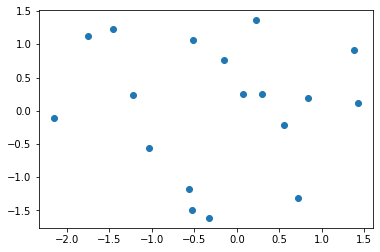

In [ ]:
embedding = torch.nn.Embedding(len(vocab), 5)

# embed all tokens of our vocabulary
x = torch.arange(len(vocab))
emb = embedding(x).detach().cpu().numpy()

plt.scatter(emb[:, 0], emb[:, 1]);

As always, we need to balance the complexity of our networks: a larger embedding will increase the number of parameters in our model, but increase the risk of overfitting.

**(l) Would this 2-dimensional embedding space be large enough for our problem?<span style="float:right"> (1 point)</span>**

The space is big enough for defining just a few vectors representing a vocabulary of only 18 tokens. Points can be well distributed among the space.

Instead of using an embedding, we could also use a simple one-hot encoding to map the words in the vocabulary to feature vectors. However, practical applications of natural language processing never do this. Why not?

**(m) Explain the practical advantage of embeddings over one-hot encoding.<span style="float:right"> (1 point)</span>**

Embeddings require less values to represent a single category in a list. 5 vector dimensions is way easier to manage and operate with than longer vector with only one value non-equal to zero.

## 5.3 `torch.nn.Transformer` (8 points)

<div style="float: left"><a href="https://cs.ru.nl/~gvtulder/vaswani-fig-1-highlight.png"><img src="https://cs.ru.nl/~gvtulder/vaswani-fig-1-highlight.png" width="300"></a></div>

We now have all required inputs for our transformer.

Consult the documentation for the [`torch.nn.Transformer`](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) class of PyTorch. This class implements a full Transformer as described in ["Attention Is All You Need"](https://arxiv.org/pdf/1706.03762.pdf), the paper that introduced this architecture.

The `Transformer` class implements the main part of the of the Transformer architecture, shown highlighted in the image on the left (see also Fig. 1 in "Attention Is All You Need").

For a given input sequence, it applies one or more encoder layers, followed by one or more decoder layers, to compute an output sequence that we can then process further.

Because the `Transformer` class takes care of most of the complicated parts of the model, we can concentrate providing the inputs and outputs: the grayed-out areas in the image.

Check out the parameters for the `Transformer` class and the inputs and outputs of its `forward` function.
<br style="clear: both">

**(a) Which parameter of the Transformer class should we base on our embedding?<span style="float:right"> (1 point)</span>**

The d_model parameter (the first of the transformer constructor function) represents the number of dimensions of the embeddings we are predicting.

**(b) Given fixed input and output dimensions, which parameters of the Transformer can we use to change the complexity of our network?<span style="float:right"> (1 point)</span>**

We could either use more encoding or decoding layers, or even more dimenssions in the embedding.

**(c) Where should we use the masks that we defined earlier?<span style="float:right"> (1 point)</span>**

The masks should be used when feeding the source and target of the Transformer block.

### Building a network

**(d) Complete the code for the TransformerNetwork.<span style="float:right"> (5 points)</span>**

Construct a network with the following architecture (see the image in the previous section for an overview):
1. An embedding layer that embeds the input tokens into a space of size `dim_hidden`.
2. A dropout layer (not shown in the image).
3. A [Transformer](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html) with the specified parameters (`dim_hidden`, `num_heads`, `num_layers`, `dim_feedforward`, and `dropout`).<br>Note: you will need to pass `batch_first=True`, to indicate that the first dimension runs over the batch and not over the sequence.
4. A final linear prediction layer that takes the output of the transformer to `dim_vocab` possible classes.

Don't worry about positional encoding for now, we will add that later.

The `forward` function should generate the appropriate masks and combine the layers defined in `__init__` to compute the output.

In [ ]:
class TransformerNetwork(torch.nn.Module):
    def __init__(self,
                 dim_vocab = len(vocab), padding_token=vocab['<pad>'],
                 num_layers=2, num_heads=4, dim_hidden=64, dim_feedforward=64,
                 dropout=0.01, positional_encoding=False):
        super().__init__()
        self.padding_token = padding_token
        self.embedding    = torch.nn.Embedding(dim_vocab, dim_hidden)
        self.dropout      = torch.nn.Dropout()
        self.transformer  = torch.nn.Transformer(dim_hidden, num_heads, num_layers, num_layers, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.predict      = torch.nn.Linear(dim_hidden, dim_vocab)
        if positional_encoding:
            self.pos_encoding = ... # Fill this in later
        else:
            self.pos_encoding = torch.nn.Identity()

    def forward(self, src, tgt):
        embeded_src = self.dropout(self.embedding(src))
        embeded_tgt = self.dropout(self.embedding(tgt))
        src_mask = generate_square_subsequent_mask(src.shape[1])
        tgt_mask = generate_square_subsequent_mask(tgt.shape[1])
        src_padding_mask = generate_padding_mask(src, self.padding_token)
        tgt_padding_mask = generate_padding_mask(tgt, self.padding_token)
        result = self.transformer(embeded_src, embeded_tgt, src_mask, tgt_mask, src_key_padding_mask=src_padding_mask, tgt_key_padding_mask=tgt_padding_mask)
        return self.predict(result)

**(e) Try the transformer with an example batch.**

In [ ]:
net = TransformerNetwork()
x, y = next(iter(train_loader))
bos = torch.tensor(vocab['<bos>']).expand(y.shape[0], 1)
y_prev = torch.cat((bos, y[:, :-1]), axis=1)

print('x.shape', x.shape)
print('y.shape', y.shape)
print('y_prev.shape', y_prev.shape)

y_pred = net(x, y_prev)
print('y_pred.shape', y_pred.shape)

# check the shape against what we expected
np.testing.assert_equal(list(y_pred.shape), [y.shape[0], y.shape[1], len(vocab)])

x.shape torch.Size([125, 9])
y.shape torch.Size([125, 5])
y_prev.shape torch.Size([125, 5])
y_pred.shape torch.Size([125, 5, 18])


We can convert these predictions to tokens (but they're obviously random):

In [ ]:
print(decode_tokens(torch.argmax(y_pred, dim=2))[:5])

[['1' '6' '6' '1' '5']
 ['/' '*' '6' '5' '6']
 ['<pad>' '2' '/' '<pad>' '0']
 ['<pad>' '6' '6' '6' '+']
 ['<pad>' '<bos>' '6' '6' '6']]


## 5.4 Training (9 points)

### Training loop

**(a) Write a training loop for the transformer model.<span style="float:right"> (4 points)</span>**

See last week's assignment for inspiration.
The code is mostly the same with the following changes:
 * The cross-entropy loss function should ignore all `<pad>` tokens. (Use `ignore_index`, see the [documentation of CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).)
 * The accuracy() function from last week should similarly ignore padding tokens (Hint: `correct[y != ignore_index]`)
 * The network expects `y_prev` as an extra input.
 * The output of the network contains a batch of N samples, with maximum length L, and gives logits over C classes, so it has size (N,L,C). But `CrossEntropyLoss` and `accuracy` expect a tensor of size (N,C,L). You can use [torch.Tensor.transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html) to change the output to the right shape.

In [ ]:
def accuracy(y_hat, y):
    y_hat = torch.argmax(y_hat, axis=1).to(y.dtype)
    correct = (y_hat == y).to(torch.float32)
    return torch.mean(correct[y != vocab['<pad>']])

def train(net, data_loaders, epochs=100, lr=0.001, device=device):
    """
    Trains the model net with data from the data_loaders['train'] and data_loaders['val'].
    """
    net = net.to(device)

    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    animator = d2l.Animator(xlabel='epoch',
                            legend=['train loss', 'train acc', 'validation acc'],
                            figsize=(10, 5))

    timer = {'train': d2l.Timer(), 'val': d2l.Timer()}
    for epoch in range(0, epochs):
      metrics = {'train': d2l.Accumulator(3), 'val': d2l.Accumulator(3)}
      for phase in ('train', 'val'):
        net.train(phase == 'train')
        for i, (x, y) in enumerate(data_loaders[phase]):
          timer[phase].start()
          bos = torch.tensor(vocab['<bos>']).expand(y.shape[0], 1)
          y_prev = torch.cat((bos, y[:, :-1]), axis=1)
          y_hat = net(x, y_prev)
          transposed = torch.transpose(y_hat, 1, 2)
          loss = torch.nn.CrossEntropyLoss(ignore_index = vocab['<pad>'])(transposed, y)
          if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
          acc = accuracy(transposed, y)
          metrics[phase].add(loss * x.shape[0],
            acc * x.shape[0],
            x.shape[0])
          timer[phase].stop()
      animator.add(epoch + 1,
        (metrics['train'][0] / metrics['train'][2],
          metrics['train'][1] / metrics['train'][2],
          metrics['val'][1] / metrics['val'][2]))
    train_loss = metrics['train'][0] / metrics['train'][2]
    train_acc  = metrics['train'][1] / metrics['train'][2]
    val_acc    = metrics['val'][1] / metrics['val'][2]
    examples_per_sec = metrics['train'][2] * epochs / timer['train'].sum()

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'val acc {val_acc:.3f}')
    print(f'{examples_per_sec:.1f} examples/sec '
          f'on {str(device)}')

### Experiment

**(b) Train a transformer network. Use 100 epochs with a learning of 0.001<span style="float:right"> (no points)</span>**

train loss 0.813, train acc 0.695, val acc 0.746
1724.2 examples/sec on cpu


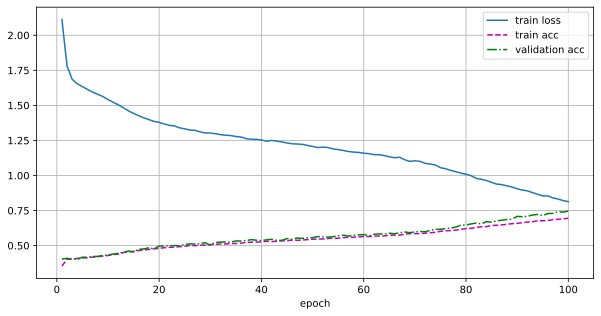

In [ ]:
net = TransformerNetwork()
train(net, data_loaders, epochs=100, lr=0.001)

**(c) Briefly discuss the results. Has the training converged? Is this a good calculator?<span style="float:right"> (1 point)</span>**

The results are fair, but the training has not converged yet. The loss seems to be decreasing even when being close to epoch nº100, while the oppossite appears to happen with the accuracy. We do not think this calculator is good because it could be improved further.

**(d) Run the trained network with input `"123+123"` and `"321+321"`.<span style="float:right"> (1 point)</span>**

In [ ]:
def predict(net, q, a):
    # Run net to predict the output given the input q=a.
    with torch.no_grad():
        bos = torch.tensor(vocab['<bos>']).expand(a.shape[0], 1)
        a_prev = torch.cat((bos, a[:, :-1]), axis=1)
        y_hat = net(q, a_prev)
        return y_hat

padded_q = []
padded_a = []

for q, a in [('123+123', '246'), ('321+321', '642')]:
  tokens_q = tokenize_and_encode(q, vocab)
  tokens_a = tokenize_and_encode(a, vocab)
  padded_q.append(pad_or_trim(tokens_q, 7, vocab))
  padded_a.append(pad_or_trim(tokens_a, 3, vocab))
res = predict(net, torch.tensor(padded_q), torch.tensor(padded_a))
print(decode_tokens(torch.argmax(res, dim=2)))


[['3' '2' '5']
 ['6' '5' '2']]


**(e) Compare the predictions for the first element of y. Can you explain what happens?<span style="float:right"> (1 point)</span>**

The predictions are awful and do not match the actual results

**(f) Does the validation accuracy indicate how often the model is able to answers unseen formula correctly? Explain your answer.<span style="float:right"> (1 point)</span>**

The validation accuracy is not so bad, albeit the results for our single examples were very far from the actual ones. This shows that the evaluation of unseen formulas is very likely to fail.

**(g) If the forward function takes the shifted output `y_prev` as input, how can we use it if we don't know the output yet?<span style="float:right"> (1 point)</span>**

y_prev is neccesary because we need a masked target vector to feed the outputs as they are being produced by the network. Since each output token is generated one by one, it could be feeded as they are being retrieved.

## 5.5 Positional encoding (5 points)

We did not yet include positional encoding in the network.
PyTorch does not include such an encoder, so here we copied the code from the book (slightly modified):

In [ ]:
class PositionalEncoding(nn.Module):
    """Positional encoding."""
    def __init__(self, num_hiddens, max_len=1000):
        super().__init__()
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        return X + self.P[:, :X.shape[1], :].to(X.device)

**(a) Add positional encoding to the TransformerModel.<span style="float:right"> (point given in earlier question)</span>**

In [ ]:
class TransformerNetwork(torch.nn.Module):
    def __init__(self,
                 dim_vocab=len(vocab), padding_token=vocab['<pad>'],
                 num_layers=2, num_heads=4, dim_hidden=64, dim_feedforward=64,
                 dropout=0.01, positional_encoding=True):
        super().__init__()
        self.padding_token = padding_token

        self.embedding    = torch.nn.Embedding(dim_vocab, dim_hidden)
        self.dropout      = torch.nn.Dropout()
        self.transformer  = torch.nn.Transformer(dim_hidden, num_heads, num_layers, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.predict      = torch.nn.Linear(dim_hidden, dim_vocab)
        if positional_encoding:
            self.pos_encoding = PositionalEncoding(dim_hidden)
        else:
            self.pos_encoding = torch.nn.Identity()

    def forward(self, src, tgt):
        embeded_src = self.pos_encoding(self.dropout(self.embedding(src)))
        embeded_tgt = self.pos_encoding(self.dropout(self.embedding(tgt)))
        src_mask = generate_square_subsequent_mask(src.shape[1])
        tgt_mask = generate_square_subsequent_mask(tgt.shape[1])
        src_padding_mask = generate_padding_mask(src, self.padding_token)
        tgt_padding_mask = generate_padding_mask(tgt, self.padding_token)
        result = self.transformer(embeded_src, embeded_tgt, src_mask, tgt_mask, src_key_padding_mask=src_padding_mask, tgt_key_padding_mask=tgt_padding_mask)
        return self.predict(result)

**(b) Construct and train a network with positional encoding<span style="float:right"> (1 point)</span>**

train loss 0.746, train acc 0.716, val acc 0.706
1202.1 examples/sec on cpu


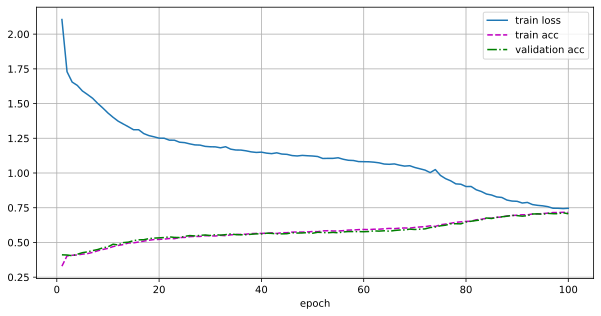

In [ ]:
net_pos = TransformerNetwork()
train(net_pos, data_loaders, epochs=100, lr=0.001)

**(c) How does the performance of a model with positional encoding compare to a model without?<span style="float:right"> (1 point)</span>**

We can see that positial encoding improves the results of our Transformer Network. Both accuracies and loss are considerably improved. That is because If we don't use positional encoding the model doesn't have a way to take the sequence of the input into consideration. This is because the output is computed independently and therefore does not model the sequence. It would mean that the sequence of a sentence is not important.

**(d) Run the trained network with input `"123+123"` and `"321+321"`.<span style="float:right"> (no points)</span>**

In [ ]:
def predict(net, q, a):
    # Run net to predict the output given the input q=a.
    with torch.no_grad():
        bos = torch.tensor(vocab['<bos>']).expand(a.shape[0], 1)
        a_prev = torch.cat((bos, a[:, :-1]), axis=1)
        y_hat = net(q,a_prev)
        return y_hat

padded_q = []
padded_a = []

for q, a in [('123+123', '246'), ('321+321', '642')]:
  tokens_q = tokenize_and_encode(q, vocab)
  tokens_a = tokenize_and_encode(a, vocab)
  padded_q.append(pad_or_trim(tokens_q, 7, vocab))
  padded_a.append(pad_or_trim(tokens_a, 4, vocab))
res = predict(net_pos, torch.tensor(padded_q), torch.tensor(padded_a))
print(decode_tokens(torch.argmax(res, dim=2)))

[['2' '3' '7' '<eos>']
 ['6' '3' '2' '<eos>']]


**(e) Compare the predictions for the first element of y with what you found earlier. Can you explain what happens?<span style="float:right"> (1 point)</span>**

The first element is now perfectly predicted and the rest ones are pretty close to the correct ones.

**(f) Explain in your own words why positional encoding is used in transformer networks.<span style="float:right"> (1 point)</span>**

As we said in previous question, without positional encoding  the output is computed independently and therefore does not model the sequence. The positional encoding takes into account the sequence of a sentence.

**(g) Look at the learning curve. Can you suggest a way to improve the model?<span style="float:right"> (1 point)</span>**

Since the learning increased around the last epochs, this means that we could have increased the lerning rate to achieve a more rapid convergence. Or we could have used more epochs instead.

**(h) Optional: if time permits, try to train an even better model**

## 5.6 Predicting for new samples (5 points)

Predicting an output given a new sample requires an appropriate search algorithm (see [d2l chapter 10.8](https://d2l.ai/chapter_recurrent-modern/beam-search.html)). Here, we will implement the simplest form: a greedy search algorithm that selects the token with the highest probability at each time step.

**(a) Describe this search strategy in pseudo-code.<span style="float:right"> (1 point)</span>**

```
output = []
input = [ ( ... input tokens ...) ]
tokens = [ ( ... possible tokens ... ) ]
for i in (0 to input.size)
  max_token_probability_index = probabilities.indexOf(max(probabilities[i]))
  output.append( tokens[max_token_probability_index] )
return outoput;
```



**(b) Implement a greedy search function to predict a sequence using `net_pos`.<span style="float:right"> (2 points)</span>**

In [ ]:
def predict_greedy(net, src, length):
    # predict an output sequence of the given (maximum) length given input string src
    with torch.no_grad():
        tokens_q = tokenize_and_encode(src, vocab)
        padded_q = torch.tensor([pad_or_trim(tokens_q, length, vocab)])
        matrix = []
        for v in vocab.idx_to_token:
          preds = []
          v_t = torch.tensor([[vocab[v]]])
          for time_step in range(0,length+1):
            y_hat = net(padded_q,v_t)
            preds.append(y_hat)
          matrix.append(preds)
        i = 0
        output = []
        for token in src:
          output.append(matrix[vocab[token]][i])
          i += 1
        return output


predicted_sequence = predict_greedy(net_pos, '123+123', 6)
#print(predicted_sequence)
print([t.numpy() for t in decode_tokens(predicted_sequence)])

**(c) Does this search strategy give a high-quality prediction? Why, or why not?<span style="float:right"> (1 point)</span>**

This search strategy give us a a good quality prediction, is not a high-quality prediction because this strategy aims mainly at reducing the computational cost, so the choice is made on the basis of the token with the highest conditional probability.

**(d) What alternative search strategy could we use to improve the predictions? Why would this help?<span style="float:right"> (1 point)</span>**

If the goal is to obtain the most likely sequence, we may consider using exhaustive search: exhaustively enumerate all the possible output sequences with their conditional probabilities, and then output the one that scores the highest predicted probability.The problem os this kind of searc is the computational cost. On another hand, we have the Beam search strategy, this one is attempt to provide a tradeoff between accuracy versus computational cost via its flexible choice of the beam size.

## 5.7 Discussion (5 points)

Last week, we looked at recurrent neural networks such as the LSTM. Both recurrent neural networks and transformers work with sequences, but in recent years the transformer has become more popular than the recurrent models.

**(a) What is an important advantage of transformers over recurrent neural networks?<span style="float:right"> (1 point)</span>**

The main advantage is related to the possibility of paying attention to specific parts of the input. Instead of just operating with them as if they were independent tokens with little relation.

**(b) Does this advantage also hold when predicting outputs for new sequences? Why, or why not?<span style="float:right"> (1 point)</span>**

If the model is well trained and parametrized, i shopuld be capable of using attention when processing other inputs as well.

**(c) Why is positional encoding often used in transformers, but not in convolutional or recurrent neural networks?<span style="float:right"> (1 point)</span>**

Because the other neural networks have no sense of the position of each token alongside the input (RNNs might not even have the whole input at hand). So the positional encoding allows to observe with different attention to each specifi token conforming the input.


The structure of a recurrent neural network makes it very suitable for online predictions, such as real-time translation, because it only depends on prior inputs. (Note: 'online' means giving predictions immediately, as opposed to collecting a full dataset and analyzing it afterwards, it has nothing to do with the internet)

**(d) How would a transformer work in an online application? Do you need to change the architecture?<span style="float:right"> (1 point)</span>**

Since the transformer needs to process the whole input all at once, we could train the network to handle each separate token as an input, computing the online output one by one
Also, it would be possible to stack many transformers feeding their outputs as inputs to others, so that the network architecture allows handling many inputs at once.

**(e) How would you train a transformer for an online task?<span style="float:right"> (1 point)</span>**

The input would be given one by one to the first transformer and the output would be later retrieved from each of the layers.
The output size could be as big as the number of layers in the architecture.  

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 47 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 542f88c / 2022-10-05</span>